The error you're encountering arises because there's a mismatch between the devices of tensors and model parameters. Specifically, some tensors are on the CPU while they should be on the MPS device. This can happen due to several reasons, including how tensors are created and how the model is moved to the device.

Here's how you can fix it:

1. **Ensure All Model Parameters Are Moved to Device:**

   Although you called `model.to(device)`, sometimes not all submodules or parameters are correctly moved, especially when using certain versions of PyTorch or when defining custom modules.

2. **Modify the VAE Class to Use Functional Activations:**

   Using `nn.ReLU()` and `nn.Sigmoid()` as class attributes can sometimes lead to unexpected behavior. Instead, use the functional API from `torch.nn.functional`.

3. **Explicitly Specify the Device When Creating New Tensors:**

   When creating new tensors (e.g., random noise in the reparameterization trick), make sure they're created on the correct device.

Below is the updated code with these fixes applied:



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary


In [2]:
# Check for device availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")


Using MPS device


In [ ]:
# Define transformations
transform = v2.Compose([v2.ToTensor(), v2.Normalize((0.1307,), (0.3081,))])

# Load MNIST dataset
dataset = MNIST(root="../data", train=True, download=True, transform=transform)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)


In [4]:
# Define the VAE model
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, input_dim=28 * 28, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(
            hidden_dim, latent_dim
        )  # For mean of latent distribution
        self.fc_logvar = nn.Linear(
            hidden_dim, latent_dim
        )  # For log variance of latent distribution

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(
            std, device=std.device
        )  # Ensure eps is on the same device
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h3))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [5]:
# Define the loss function (reconstruction loss + KL divergence)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28 * 28), reduction="sum"
    )
    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [17]:
# Initialize the model, optimizer
model = VAE().to(device)

# Verify that all parameters are on the correct device
for name, param in model.named_parameters():
    if param.device != device:
        print(f"Parameter {name} is on {param.device}, expected {device}.")
    else:
        print(f"Parameter {name} is on {param.device}.")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Print model summary using torchinfo
summary(model, input_size=(batch_size, 1, 28, 28), device=device)

# Training settings
num_epochs = 15


Parameter fc1.weight is on mps:0, expected mps.
Parameter fc1.bias is on mps:0, expected mps.
Parameter fc_mu.weight is on mps:0, expected mps.
Parameter fc_mu.bias is on mps:0, expected mps.
Parameter fc_logvar.weight is on mps:0, expected mps.
Parameter fc_logvar.bias is on mps:0, expected mps.
Parameter fc3.weight is on mps:0, expected mps.
Parameter fc3.bias is on mps:0, expected mps.
Parameter fc4.weight is on mps:0, expected mps.
Parameter fc4.bias is on mps:0, expected mps.


In [18]:
# Training and validation loops with early stopping
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    ):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)

    print(
        f"Epoch {epoch}: Average training loss: {train_loss:.4f}, Average validation loss: {val_loss:.4f}"
    )


Epoch 1/15: 100%|██████████| 375/375 [00:03<00:00, 106.70it/s]


Epoch 1: Average training loss: 193.6897, Average validation loss: 173.7313


Epoch 2/15: 100%|██████████| 375/375 [00:03<00:00, 108.17it/s]


Epoch 2: Average training loss: 169.2629, Average validation loss: 166.2625


Epoch 3/15: 100%|██████████| 375/375 [00:03<00:00, 115.57it/s]


Epoch 3: Average training loss: 164.7131, Average validation loss: 163.4906


Epoch 4/15: 100%|██████████| 375/375 [00:03<00:00, 112.71it/s]


Epoch 4: Average training loss: 162.2535, Average validation loss: 161.4509


Epoch 5/15: 100%|██████████| 375/375 [00:03<00:00, 118.54it/s]


Epoch 5: Average training loss: 160.4115, Average validation loss: 159.7759


Epoch 6/15: 100%|██████████| 375/375 [00:03<00:00, 114.61it/s]


Epoch 6: Average training loss: 158.9941, Average validation loss: 158.6339


Epoch 7/15: 100%|██████████| 375/375 [00:03<00:00, 111.18it/s]


Epoch 7: Average training loss: 157.9266, Average validation loss: 157.6306


Epoch 8/15: 100%|██████████| 375/375 [00:03<00:00, 111.49it/s]


Epoch 8: Average training loss: 156.9750, Average validation loss: 157.1134


Epoch 9/15: 100%|██████████| 375/375 [00:03<00:00, 116.45it/s]


Epoch 9: Average training loss: 156.3093, Average validation loss: 156.6048


Epoch 10/15: 100%|██████████| 375/375 [00:03<00:00, 118.74it/s]


Epoch 10: Average training loss: 155.6601, Average validation loss: 155.9950


Epoch 11/15: 100%|██████████| 375/375 [00:03<00:00, 123.04it/s]


Epoch 11: Average training loss: 155.0044, Average validation loss: 155.6989


Epoch 12/15: 100%|██████████| 375/375 [00:03<00:00, 118.94it/s]


Epoch 12: Average training loss: 154.5484, Average validation loss: 155.2437


Epoch 13/15: 100%|██████████| 375/375 [00:03<00:00, 121.88it/s]


Epoch 13: Average training loss: 154.0984, Average validation loss: 155.0070


Epoch 14/15: 100%|██████████| 375/375 [00:03<00:00, 122.61it/s]


Epoch 14: Average training loss: 153.6422, Average validation loss: 154.4370


Epoch 15/15: 100%|██████████| 375/375 [00:02<00:00, 125.96it/s]


Epoch 15: Average training loss: 153.2287, Average validation loss: 154.3138


RuntimeError: Parent directory ../models does not exist.

In [19]:
torch.save(model.state_dict(), "./models/best_model.pt")

In [20]:
# Load the best model
model.load_state_dict(torch.load("./models/best_model.pt", map_location=device))

# Plot the 2D latent space
# Collect all latent variables and labels for validation set
model.eval()
latents = []
labels = []
with torch.no_grad():
    for data, target in val_loader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        latents.append(z.cpu().numpy())
        labels.append(target.cpu().numpy())

latents = np.concatenate(latents)
labels = np.concatenate(labels)


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_30446/3882877985.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/be

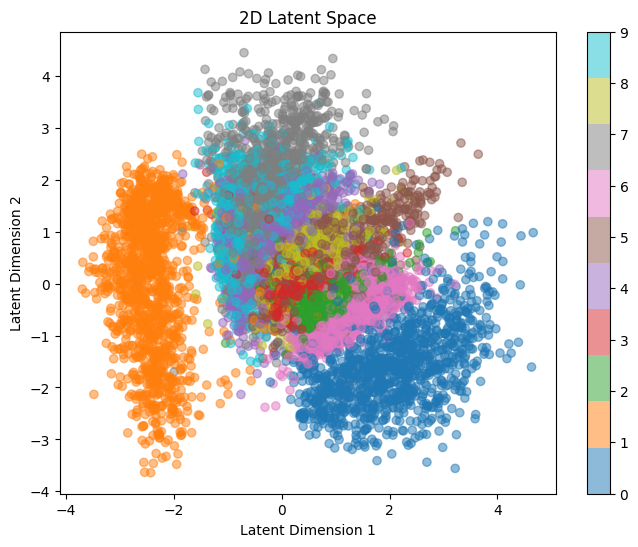

In [21]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap="tab10", alpha=0.5)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space")
plt.show()


In [27]:
# Display original images and their reconstructions
def show_images(original, reconstructed, num_images=8):
    original = original.view(-1, 1, 28, 28)
    reconstructed = reconstructed.view(-1, 1, 28, 28)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(original[i, 0].cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i, 0].cpu().detach(), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()


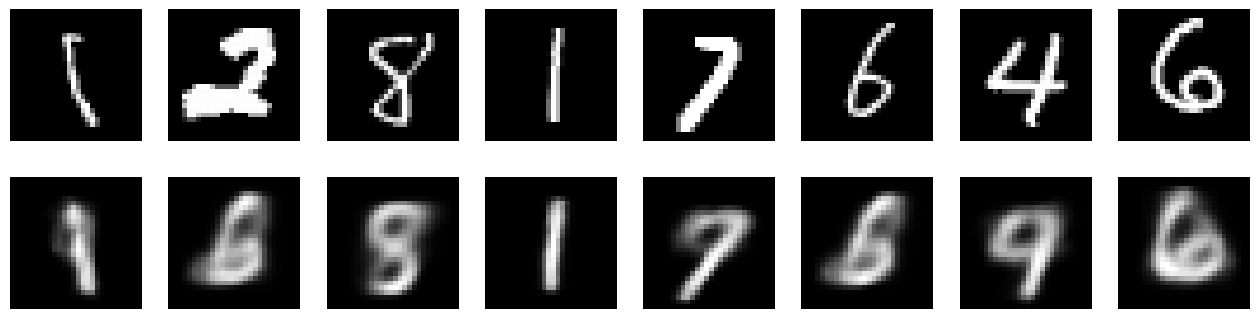

In [28]:
# Get a batch of validation data
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)
recon_images, mu, logvar = model(images)
show_images(images, recon_images)


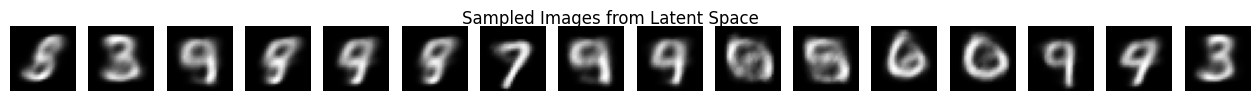

In [30]:
# Sample new images from the latent space and display them

latent_dim = 2
# Sample new images from the latent space
with torch.no_grad():
    z = torch.randn(
        16, latent_dim, device=device
    )  # Sample from standard normal on correct device
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

    # Plot sampled images
    fig, axes = plt.subplots(1, 16, figsize=(16, 1))
    for i in range(16):
        axes[i].imshow(sample[i, 0], cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Sampled Images from Latent Space")
    plt.show()




**Explanation of Fixes:**

1. **Model Parameters Verification:**
   - **Added Verification Print Statements:**
     After moving the model to the device, we print out the device of each parameter to ensure that all parameters are correctly moved. If any parameter is not on the expected device, it will be reported.

   ```python
   for name, param in model.named_parameters():
       if param.device != device:
           print(f"Parameter {name} is on {param.device}, expected {device}.")
       else:
           print(f"Parameter {name} is on {param.device}.")
   ```

2. **Using Functional API for Activation Functions:**
   - **Removed Self-Defined Activations:**
     Removed `self.relu` and `self.sigmoid` from the `__init__` method.
   - **Utilized Functional Activations:**
     Replaced `self.relu(...)` with `F.relu(...)` and `self.sigmoid(...)` with `torch.sigmoid(...)` in the `encode`, `decode`, and `forward` methods.

   ```python
   import torch.nn.functional as F

   # Use F.relu and torch.sigmoid in the methods
   ```

3. **Ensuring Random Tensors Are on the Correct Device:**
   - **Reparameterization Trick Adjustment:**
     Modified the `reparameterize` method to explicitly set the device for `eps`.

   ```python
   eps = torch.randn_like(std, device=std.device)  # Ensure eps is on the same device
   ```

   - **Sampling from Latent Space Adjustment:**
     Ensured that `z` is created directly on the correct device when sampling new images.

   ```python
   z = torch.randn(64, 2, device=device)  # Ensure z is on the correct device
   ```

4. **Model Summary Update:**
   - **Set the Device for Model Summary:**
     In the `summary` function call, set the `device` parameter to ensure the model is summarized on the correct device.

   ```python
   summary(model, input_size=(batch_size, 1, 28, 28), device=device)
   ```

5. **Model State Loading Update:**
   - **Set Map Location in `load_state_dict`:**
     When loading the saved model state, explicitly set the `map_location` to the correct device.

   ```python
   model.load_state_dict(torch.load('best_model.pt', map_location=device))
   ```

**Additional Notes:**

- **Version Compatibility:**
  - Make sure you are using PyTorch version `1.12` or later, which has improved support for the MPS backend. You can check your PyTorch version using:

    ```python
    import torch
    print(torch.__version__)
    ```

  - If you have an older version, consider upgrading:

    ```bash
    pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
    ```

- **MPS Support Limitations:**
  - The MPS backend is still under development, and some operations may not be fully supported. If you continue to experience issues, consider using the CPU device until the MPS backend is more stable.

- **Random Seed for Reproducibility:**
  - If you wish to have reproducible results, you can set the random seed:

    ```python
    torch.manual_seed(0)
    ```

- **Potential Performance Considerations:**
  - Using `device='mps'` may not always lead to performance improvements compared to the CPU, depending on the current state of MPS support in PyTorch.

- **Error Handling Enhancements:**
  - Consider adding try-except blocks to catch and handle exceptions, providing more context when an error occurs.

**Testing the Fixes:**

Before running the full training, you can test whether the error is resolved by running a forward pass with a small batch:

```python
# Test forward pass
dataiter = iter(train_loader)
images, _ = dataiter.next()
images = images.to(device)
recon_images, mu, logvar = model(images)
print("Forward pass successful.")
```

If this runs without errors, it indicates that the device mismatch issue has been resolved.

**Conclusion:**

By ensuring that all tensors and model parameters are on the same device and using the functional API for activations, the device mismatch error should be resolved. If you continue to face issues, please let me know, and we can investigate further.

Certainly! Here are several suggestions for improving the Variational Autoencoder (VAE) model you implemented for the MNIST dataset. I'll provide explanations for each suggestion, focusing on how they could enhance the model's performance, representation capacity, and generalization ability. These improvements range from architectural changes to training strategies.

---

### 1. **Use Convolutional Neural Networks (CNNs)**

**Reasoning:**

- **Spatial Hierarchies:** CNNs are adept at capturing spatial hierarchies in image data. They can learn local patterns (like edges and textures) and combine them to form higher-level representations.
- **Parameter Efficiency:** Convolutional layers share weights across spatial locations, reducing the number of parameters compared to fully connected layers, leading to more efficient learning.
- **Better Reconstruction Quality:** For image data, CNN-based VAEs generally produce higher-quality reconstructions because they preserve spatial relationships.

**Suggestion:**

- **Encoder:**
  - Replace the initial fully connected layers with convolutional layers.
  - Use a series of convolutional layers with increasing feature maps and downsampling (via strides or pooling) to reduce spatial dimensions progressively.
- **Decoder:**
  - Use transposed convolutional layers (also known as deconvolutions) to upsample and reconstruct the image from the latent representation.
  - Ensure that the decoder mirrors the encoder's architecture.
- **Architecture Details:**
  - Apply techniques like padding to maintain appropriate spatial dimensions.
  - Use activation functions and batch normalization as needed.

---

### 2. **Increase Latent Space Dimensionality**

**Reasoning:**

- **Capturing Complex Variability:** A 2D latent space might be too restrictive for capturing all the nuances in the MNIST dataset.
- **Higher Capacity for Information:** Increasing the size of the latent space allows the model to store more information about the input data, potentially leading to better reconstructions and more meaningful latent representations.

**Suggestion:**

- **Adjust Latent Dimension:** Experiment with latent dimensions of 10, 20, or even higher to see how it impacts reconstruction quality and latent space structure.
- **Visualization Considerations:** When using higher-dimensional latent spaces, use dimensionality reduction techniques like t-SNE or PCA to visualize the latent space.

---

### 3. **Implement Batch Normalization and Dropout**

**Reasoning:**

- **Batch Normalization:**
  - **Stabilizes Learning:** By normalizing the inputs to each layer, batch normalization helps stabilize and accelerate the training process.
  - **Reduces Sensitivity to Initialization:** It can reduce the dependence on weight initialization and make the network more robust.
- **Dropout:**
  - **Prevents Overfitting:** By randomly dropping units during training, dropout prevents the network from relying too heavily on specific nodes, promoting generalization.

**Suggestion:**

- **Batch Normalization:**
  - Add batch normalization layers after convolutional or fully connected layers and before activation functions.
- **Dropout:**
  - Introduce dropout layers with a suitable dropout rate (e.g., 0.3 to 0.5) in the encoder and decoder networks.
- **Note:**
  - Be cautious with the placement of batch normalization and dropout to avoid negatively impacting the model's ability to learn.

---

### 4. **Experiment with Different Activation Functions**

**Reasoning:**

- **Activation Functions Impact Learning Dynamics:**
  - Functions like Leaky ReLU, ELU, or SELU can mitigate issues like the dying ReLU problem and can lead to faster convergence.
  - They can improve the flow of gradients during backpropagation, especially in deeper networks.

**Suggestion:**

- **Try Alternative Activations:**
  - Replace standard ReLU with LeakyReLU, which allows a small gradient when the unit is not active.
  - Experiment with ELU or SELU, which have self-normalizing properties.
- **Evaluate Performance:**
  - Compare training curves and reconstruction quality when using different activation functions.

---

### 5. **Adjust the Loss Function with Beta-VAE**

**Reasoning:**

- **Control Over Reconstruction vs. Regularization:**
  - The standard VAE loss balances the reconstruction loss and the Kullback-Leibler (KL) divergence equally.
  - By introducing a weighting factor (beta), you can control the emphasis on latent space regularization.
- **Enhanced Disentanglement:**
  - Beta-VAE has been shown to encourage disentangled representations in the latent space, where different dimensions capture independent factors of variation.

**Suggestion:**

- **Introduce a Beta Hyperparameter:**
  - Modify the loss function to include a beta term multiplying the KL divergence:
    \[
    \text{Loss} = \text{Reconstruction Loss} + \beta \times \text{KL Divergence}
    \]
- **Experiment with Beta Values:**
  - Start with beta values greater than 1 (e.g., 4 or 10) to emphasize disentanglement.
  - Observe the impact on reconstruction quality and latent space structure.

---

### 6. **Implement Learning Rate Scheduling**

**Reasoning:**

- **Adaptive Learning Rates:**
  - Adjusting the learning rate during training can help the optimizer escape plateaus and converge to better minima.
  - Reducing the learning rate when the validation loss stops improving can fine-tune the model.

**Suggestion:**

- **Use Learning Rate Schedulers:**
  - Implement schedulers like `ReduceLROnPlateau` which reduces the learning rate when a metric (e.g., validation loss) has stopped improving.
  - Alternatively, use schedulers like `StepLR` or `ExponentialLR` to reduce the learning rate at set intervals or exponentially over time.
- **Monitor Metrics:**
  - Use validation loss as the metric to determine when to adjust the learning rate.

---

### 7. **Enhance Early Stopping Mechanism**

**Reasoning:**

- **Prevent Overfitting and Wasted Computation:**
  - A well-tuned early stopping mechanism can halt training at the optimal point.
  - Adjusting the patience or adding new criteria can improve the effectiveness.

**Suggestion:**

- **Adjust Patience:**
  - Experiment with different patience values to find a good balance between allowing the model to improve and preventing overfitting.
- **Use Smoothed Metrics:**
  - Consider using a moving average or exponential smoothing of validation loss to make early stopping decisions.
- **Monitor Additional Metrics:**
  - Incorporate other metrics like validation accuracy or reconstruction quality.

---

### 8. **Use Alternative Reconstruction Losses**

**Reasoning:**

- **Suitability to Data Distribution:**
  - Binary cross-entropy assumes pixel intensities are modeled as Bernoulli variables, which may not be accurate for grayscale images.
  - Mean squared error (MSE) treats pixel intensities as continuous variables.

**Suggestion:**

- **Try MSE Loss:**
  - Replace the binary cross-entropy reconstruction loss with MSE loss.
- **Combined Losses:**
  - Experiment with a combination of BCE and MSE or other loss functions like SSIM loss for structural similarity.
- **Evaluate Impact:**
  - Assess how the change in loss function affects the visual quality of reconstructions and the training dynamics.

---

### 9. **Apply Data Augmentation Techniques**

**Reasoning:**

- **Increase Data Diversity:**
  - Data augmentation can help the model generalize better by exposing it to various transformations of the data.
- **Prevent Overfitting:**
  - Augmentations can act as a regularizer by preventing the model from focusing on specific patterns.

**Suggestion:**

- **Augmentation Strategies:**
  - Apply random rotations, shifts, scaling, and elastic deformations to the training images.
- **Considerations:**
  - Ensure that augmentations make sense for MNIST digits and don't distort them beyond recognition.
- **Implementation:**
  - Use PyTorch's `transforms` module to apply augmentations during data loading.

---

### 10. **Implement a Conditional VAE (CVAE)**

**Reasoning:**

- **Incorporate Label Information:**
  - Conditioning the VAE on class labels can help the model learn more discriminative latent representations.
- **Controlled Generation:**
  - A CVAE can generate images conditioned on specific classes, allowing for controlled sampling.

**Suggestion:**

- **Modify the Encoder and Decoder:**
  - Concatenate one-hot encoded labels to the input of the encoder.
  - In the decoder, feed the latent vector along with the label information to reconstruct the input.
- **Adjust Loss Function:**
  - Ensure that the loss function appropriately accounts for the conditional inputs.
- **Applications:**
  - Use the CVAE to generate digits of a specific class by sampling from the conditioned latent space.

---

### 11. **Use KL Annealing**

**Reasoning:**

- **Balance Training Dynamics:**
  - At the start of training, the model might focus too much on minimizing KL divergence, causing the decoder to receive poor gradient signals.
- **Improve Latent Representations:**
  - Gradually increasing the KL divergence weight allows the model to first learn to reconstruct data well before shaping the latent space.

**Suggestion:**

- **KL Annealing Schedule:**
  - Implement a schedule where the beta parameter in the loss function increases from 0 to 1 over a certain number of epochs or iterations.
- **Implementation:**
  - Update beta each epoch or batch according to a predefined schedule (e.g., linear, sigmoid).
- **Monitor Effects:**
  - Observe whether this strategy leads to better reconstructions and latent space regularization.

---

### 12. **Experiment with Different Optimizers**

**Reasoning:**

- **Optimization Dynamics:**
  - Different optimizers can offer various advantages in terms of convergence speed and stability.
- **Handling Sparse Gradients:**
  - Some optimizers are better suited for handling sparse gradients or noisy loss functions.

**Suggestion:**

- **Try Optimizers like:**
  - **RMSprop:** Adapts the learning rate based on a moving average of squared gradients.
  - **AdamW:** Similar to Adam but decouples weight decay from the gradient update, leading to better regularization.
  - **SGD with Momentum:** May provide better generalization in some cases.
- **Hyperparameter Tuning:**
  - Adjust learning rates and optimizer-specific hyperparameters when switching optimizers.

---

### 13. **Introduce Regularization Techniques**

**Reasoning:**

- **Prevent Overfitting:**
  - Regularization methods can help the model generalize better to unseen data.
- **Encourage Sparse Representations:**
  - Regularization can promote sparsity or other desirable properties in the network weights.

**Suggestion:**

- **Weight Decay:**
  - Add L2 regularization to the optimizer by setting a non-zero weight decay parameter.
- **Sparse Activation Regularization:**
  - Penalize the activations of neurons to encourage sparsity.
- **Activity Regularization:**
  - Include terms in the loss function that penalize large activations.

---

### 14. **Implement Residual Connections**

**Reasoning:**

- **Facilitate Gradient Flow:**
  - Residual connections help mitigate the vanishing gradient problem in deep networks.
- **Improve Learning of Identity Functions:**
  - They allow layers to learn modifications to the identity mapping, making it easier to learn functions close to the identity.

**Suggestion:**

- **Modify the Network Architecture:**
  - Add skip connections that bypass one or more layers by adding the input of a layer to its output after a series of transformations.
- **Consider Residual Blocks:**
  - Use residual blocks in both the encoder and decoder, especially if you are using deeper networks.

---

### 15. **Explore Advanced VAE Variants**

**Reasoning:**

- **Address Limitations of Standard VAEs:**
  - Standard VAEs may struggle with producing sharp images or capturing complex data distributions.
- **Utilize More Expressive Models:**
  - Advanced models can provide better flexibility and modeling power.

**Suggestion:**

- **Normalizing Flows:**
  - Incorporate normalizing flows in the encoder to allow for more complex posterior approximations.
- **VAE-GAN Hybrid:**
  - Combine VAE with Generative Adversarial Networks to improve the realism of generated images.
- **Discrete VAEs:**
  - Use discrete latent variables (e.g., via Gumbel-Softmax) to model categorical distributions.

---

### 16. **Perform Hyperparameter Optimization**

**Reasoning:**

- **Find Optimal Settings:**
  - Properly tuned hyperparameters can significantly improve model performance.
- **Automated Search:**
  - Systematic exploration of the hyperparameter space can uncover better configurations than manual tuning.

**Suggestion:**

- **Use Hyperparameter Optimization Tools:**
  - Utilize libraries like Optuna, Hyperopt, or Ray Tune to automate the search process.
- **Parameters to Optimize:**
  - Learning rate, batch size, latent dimension size, network depth and width, activation functions, regularization weights, etc.
- **Optimization Techniques:**
  - Random search, Bayesian optimization, or evolutionary algorithms.

---

### 17. **Add Attention Mechanisms**

**Reasoning:**

- **Focus on Relevant Features:**
  - Attention allows the model to weigh the importance of different parts of the input.
- **Enhance Representational Capacity:**
  - Incorporating attention can help the model capture long-range dependencies and interactions.

**Suggestion:**

- **Self-Attention Layers:**
  - Add self-attention mechanisms in the encoder and decoder to allow the model to focus on specific features.
- **Channel and Spatial Attention:**
  - Implement attention over feature channels or spatial locations.
- **Evaluate Complexity:**
  - Be mindful of the increased computational cost associated with attention mechanisms.

---

### 18. **Visualize Latent Space Traversals**

**Reasoning:**

- **Understand Latent Representations:**
  - Visualizing how the model transitions between different latent points can provide insights into what the latent dimensions represent.
- **Debugging and Analysis:**
  - Observing latent traversals can help identify issues with the learned representations.

**Suggestion:**

- **Interpolation Between Points:**
  - Linearly interpolate between two points in the latent space and decode the intermediate representations.
- **Latent Space Arithmetic:**
  - Perform operations in the latent space (e.g., adding or subtracting latent vectors) to see how it affects generated images.
- **Visual Tools:**
  - Create grids of generated images over a range of latent variable values.

---

### 19. **Adjust Data Normalization**

**Reasoning:**

- **Consistent Data Scaling:**
  - Proper data normalization can improve training stability and convergence.
- **Match Model Assumptions:**
  - Ensuring that the data distribution matches the assumptions of the model (e.g., mean and variance expected by certain layers).

**Suggestion:**

- **Normalize Input Data:**
  - Scale pixel values to a range appropriate for the activation functions used.
  - For example, normalize to zero mean and unit variance if using ReLU activations.
- **Consider Inverse Transformations:**
  - When visualizing outputs, apply inverse transformations to bring data back to the original scale.

---

### 20. **Evaluate on Different Datasets**

**Reasoning:**

- **Test Generalization:**
  - Applying the model to new datasets can assess its robustness and adaptability.
- **Identify Limitations:**
  - Different datasets may reveal weaknesses in the model that can be addressed.

**Suggestion:**

- **Apply to Similar Datasets:**
  - Use datasets like Fashion-MNIST, KMNIST, or EMNIST.
- **Adjust Model as Needed:**
  - Modify data loaders and potentially the network architecture to accommodate differences in input size or structure.

---

### 21. **Implement Gradient Clipping**

**Reasoning:**

- **Prevent Exploding Gradients:**
  - Clipping gradients can prevent instability during training caused by excessively large gradients.
- **Improve Training Stability:**
  - Particularly useful when training recurrent or deep networks.

**Suggestion:**

- **Clip Gradients:**
  - Apply gradient clipping in the optimizer step, setting a maximum norm for gradient values.
- **Adjust Clipping Threshold:**
  - Experiment with different clipping thresholds to find a value that stabilizes training without hindering learning.

---

### 22. **Monitor and Visualize Training Metrics**

**Reasoning:**

- **Gain Insights into Training Dynamics:**
  - By tracking metrics over time, you can identify patterns, anomalies, or areas for improvement.
- **Facilitate Debugging:**
  - Visualizing training and validation losses, learning rates, and other metrics can help diagnose issues.

**Suggestion:**

- **Use TensorBoard or Similar Tools:**
  - Integrate TensorBoard to log scalars, images, histograms, etc.
- **Track Custom Metrics:**
  - Monitor metrics like KL divergence separately from reconstruction loss.
- **Analyze Histograms:**
  - Visualize weight and activation distributions to detect vanishing or exploding values.

---

### 23. **Incorporate Transfer Learning**

**Reasoning:**

- **Leverage Pre-trained Models:**
  - Using pre-trained weights can accelerate convergence and improve performance.
- **Capture General Features:**
  - Pre-trained encoders may capture general patterns that are beneficial for the task at hand.

**Suggestion:**

- **Use Pre-trained Encoders:**
  - Initialize the encoder with weights from a model pre-trained on a large dataset like ImageNet (adjusted for grayscale images).
- **Fine-Tuning:**
  - Train the model end-to-end or freeze certain layers to retain learned features.

---

### 24. **Switch to Wasserstein Autoencoders (WAE)**

**Reasoning:**

- **Alternative to KL Divergence:**
  - WAEs minimize the Wasserstein distance between distributions, which can lead to better empirical performance.
- **Improved Generated Samples:**
  - WAEs often produce sharper and more realistic samples compared to standard VAEs.

**Suggestion:**

- **Modify Objective Function:**
  - Replace the KL divergence term with a penalty based on the Wasserstein distance.
- **Implement WAE Variants:**
  - Use WAE-MMD (Maximum Mean Discrepancy) or WAE-GAN which incorporates an adversarial loss.

---

### 25. **Consider Using Disentangled VAE Models**

**Reasoning:**

- **Learn Interpretable Representations:**
  - Disentangled representations separate different generative factors, making the latent space more interpretable.
- **Facilitate Downstream Tasks:**
  - Useful for tasks like clustering, semi-supervised learning, and transfer learning.

**Suggestion:**

- **Implement Models Like:**
  - **FactorVAE:** Adds a total correlation term to the loss function to encourage factorization.
  - **β-TCVAE:** Decomposes the ELBO into interpretable components and emphasizes the total correlation term.
- **Adjust Regularization Weights:**
  - Carefully tune the weights associated with disentanglement penalties.

---

### 26. **Use Advanced Sampling Techniques**

**Reasoning:**

- **Improve Latent Space Exploration:**
  - Techniques like importance sampling can lead to better approximations of the true posterior.
- **Enhance Generative Modeling:**
  - Advanced sampling can produce more diverse and higher-quality samples.

**Suggestion:**

- **Importance Weighted Autoencoder (IWAE):**
  - Modify the VAE to use multiple samples from the posterior, improving the ELBO approximation.
- **Stochastic Variational Inference:**
  - Use more sophisticated inference methods for the latent variables.

---

### 27. **Adjust Network Initialization**

**Reasoning:**

- **Impact on Training Dynamics:**
  - Proper weight initialization can prevent issues like vanishing or exploding gradients and accelerate training.
- **Mitigate Dead Neurons:**
  - Initialization strategies can avoid neurons becoming inactive during training.

**Suggestion:**

- **Initialization Methods:**
  - Use Xavier (Glorot) initialization for layers with linear activations.
  - Apply He (Kaiming) initialization for layers followed by ReLU activations.
- **Bias Initialization:**
  - Initialize biases appropriately, such as to small positive values in certain cases.

---

### 28. **Implement Multi-Scale Architectures**

**Reasoning:**

- **Capture Features at Different Resolutions:**
  - Multi-scale architectures can learn both global and local patterns, enhancing representation capacity.
- **Improve Reconstruction Quality:**
  - Allows the decoder to generate images with fine details.

**Suggestion:**

- **Hierarchical VAE:**
  - Create a hierarchical latent space where different levels capture features at different scales.
- **Skip Connections Across Scales:**
  - Implement skip connections between encoder and decoder layers at matching scales (similar to U-Net architecture).

---

### 29. **Incorporate GAN Loss in VAE**

**Reasoning:**

- **Generate Sharper Images:**
  - GANs are known for producing high-fidelity images; combining them with VAEs can improve reconstruction realism.
- **Overcome Limitations of Pixel-wise Losses:**
  - Pixel-wise losses can lead to blurry images; adversarial losses encourage the generator to create more realistic outputs.

**Suggestion:**

- **VAE-GAN Hybrid:**
  - Add a discriminator network that distinguishes between real and generated images.
  - Train the VAE generator to both reconstruct images and fool the discriminator.
- **Adversarial Training:**
  - Use a suitable adversarial loss function (e.g., Wasserstein GAN loss with gradient penalty).

---

### 30. **Continuous Learning and Model Updates**

**Reasoning:**

- **Adapt to New Data:**
  - Continuous learning allows the model to update as new data becomes available without retraining from scratch.
- **Handle Data Distribution Shifts:**
  - The model can remain robust to changes in the data distribution over time.

**Suggestion:**

- **Implement Online Learning:**
  - Update model weights incrementally with new data batches.
- **Prevent Catastrophic Forgetting:**
  - Employ techniques like replay buffers or regularization to retain learned knowledge.

---

These suggestions provide various pathways to improve your VAE model for the MNIST dataset. Each recommendation targets different aspects of the model, such as the architecture, training strategy, loss function, or data handling. When applying these improvements, it's important to experiment systematically, adjusting one factor at a time and assessing its impact on model performance.

**Additional Considerations:**

- **Evaluation Metrics:**
  - Beyond reconstruction loss, consider using metrics like inception score or Fréchet inception distance (FID) to evaluate generative models.
- **Computational Resources:**
  - Some suggestions may significantly increase computational requirements. Ensure that you have the necessary resources or adjust the model complexity accordingly.
- **Research and References:**
  - Refer to the latest research papers and implementations for cutting-edge methods and insights.

By thoughtfully integrating these improvements and carefully analyzing their effects, you can enhance the capabilities of your VAE model and achieve better performance on the MNIST dataset.